In [28]:
import firebase_admin
import pandas as pd
import numpy as np
from firebase_admin import credentials, firestore
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['Stephen', 'Lillian', 'Ren', 'Yuanheng', 'Ethan Shao','z']
ACTIVITIES = ['sit', 'walk', 'upstair', 'downstair']
TIME_START, TIME_END = 500, 6000  
SAMPLING_RATE = 100  # Hz
OVERLAP = 0.5  # 50% overlap

In [29]:
def extract_features(chunk):
    """Extract features from a chunked acceleration segment with selected statistics."""
    feature_vector = []
    
    for axis in ['x', 'y', 'z']:
        data_series = pd.Series(chunk[axis])
        # Apply smoothing
        smoothed_data = data_series.rolling(window=5, min_periods=1).mean()
        feature_vector.extend([
            smoothed_data.mean(),                  
            smoothed_data.median(),                
            smoothed_data.std(),                   # Standard Deviation
            smoothed_data.var(),                   # Variance
            smoothed_data.min(),                   
            smoothed_data.max(),                   
        ])
    return feature_vector

In [30]:
def fetch_data(collection_name, activities, include_only):
    """Fetch raw data from Firestore."""
    data_raw, docs = [], []
    
    for person in db.collection(collection_name).stream():
        person_name = str(person.to_dict().get('name', ''))
        if person_name not in include_only:
            continue

        for activity in activities:
            for recording in db.collection(collection_name).document(person_name).collection(activity).stream():
                record = recording.to_dict()
                if 'acceleration' not in record:
                    continue

                df = pd.DataFrame(record['acceleration'])
                if 'time' in df.columns:
                    df = df[(df['time'] >= TIME_START) & (df['time'] <= TIME_END)].drop(columns=['time'])
                    data_raw.append(df)
                    docs.append({'activity': activity})

    return data_raw, docs
training_data_raw, training_docs = fetch_data("training", ACTIVITIES, INCLUDE_ONLY)
testing_data_raw, testing_docs = fetch_data("testing", ACTIVITIES, INCLUDE_ONLY)

In [31]:
def chunk_data_with_overlap(data_raw, docs, chunk_size, activities, sampling_rate, overlap=0.5):
    """Chunk raw acceleration data into smaller labeled segments using overlapping windows."""
    data, labels = [], []
    chunk_samples = int(chunk_size * sampling_rate)
    step = int(chunk_samples * (1 - overlap))  # compute step size based on overlap

    for i, df in enumerate(data_raw):
        # Slide over the data with the defined step
        for start in range(0, len(df) - chunk_samples + 1, step):
            end = start + chunk_samples
            chunk = df.iloc[start:end]
            activity = docs[i]['activity']
            label = activities.index(activity)
            data.append(extract_features(chunk))
            labels.append(label)
    return np.array(data), np.array(labels)

In [32]:
# Combine both training and testing data
all_data_raw = training_data_raw + testing_data_raw
all_docs = training_docs + testing_docs

In [33]:
# List of chunk sizes to experiment with (in seconds)
chunk_sizes = [0.25,0.5,1,1.375,2.75,5.5]

accuracies = []
best_chunk_size = None

# Loop through the chunk sizes to find the best one
for chunk_size in chunk_sizes:
    # Use overlapping window chunking
    X_all, y_all = chunk_data_with_overlap(all_data_raw, all_docs, chunk_size, ACTIVITIES, SAMPLING_RATE, OVERLAP)

    # Split into 80% training, 20% testing
    X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

    # Build a pipeline to scale data and train KNN
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('knn', KNeighborsClassifier())
    ])

    # Define hyperparameter grid for GridSearchCV
    param_grid = {
        'knn__n_neighbors': list(range(1, 16)),
        'knn__metric': ['manhattan', 'euclidean'],
        'knn__weights': ['uniform', 'distance']
    }

    # Use GridSearchCV for parameter tuning with cross-validation on training data
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)

    print(f"Best Parameters for chunk size {chunk_size}:", grid_search.best_params_)

    # Evaluate the best model on the test set
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    print(f"KNN Test Accuracy for chunk size {chunk_size}: {accuracy:.2f}")

# Identify the best chunk size based on accuracy
best_chunk_size = chunk_sizes[np.argmax(accuracies)]
print(f"Best Chunk Size: {best_chunk_size} seconds")

Best Parameters for chunk size 0.25: {'knn__metric': 'manhattan', 'knn__n_neighbors': 15, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 0.25: 0.77
Best Parameters for chunk size 0.5: {'knn__metric': 'manhattan', 'knn__n_neighbors': 5, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 0.5: 0.81
Best Parameters for chunk size 1: {'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 1: 0.90
Best Parameters for chunk size 1.375: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
KNN Test Accuracy for chunk size 1.375: 0.91
Best Parameters for chunk size 2.75: {'knn__metric': 'manhattan', 'knn__n_neighbors': 1, 'knn__weights': 'uniform'}
KNN Test Accuracy for chunk size 2.75: 0.88
Best Parameters for chunk size 5.5: {'knn__metric': 'manhattan', 'knn__n_neighbors': 4, 'knn__weights': 'distance'}
KNN Test Accuracy for chunk size 5.5: 0.65
Best Chunk Size: 1.375 seconds


KNN Test Accuracy with Best Chunk Size (1 sec): 0.89
              precision    recall  f1-score   support

         sit       0.98      1.00      0.99        48
        walk       0.92      0.94      0.93        48
     upstair       0.81      0.79      0.80        48
   downstair       0.86      0.90      0.88        48
         run       0.90      0.88      0.89        32
        jump       0.90      0.84      0.87        32

    accuracy                           0.89       256
   macro avg       0.89      0.89      0.89       256
weighted avg       0.89      0.89      0.89       256



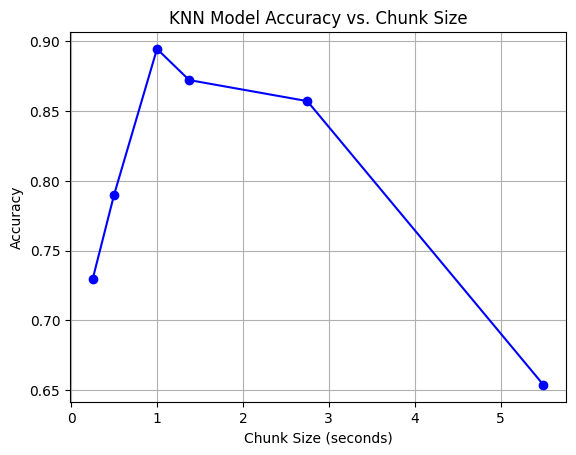

In [26]:
X_all, y_all = chunk_data_with_overlap(all_data_raw, all_docs, best_chunk_size, ACTIVITIES, SAMPLING_RATE, OVERLAP)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])

# Hyperparameters for GridSearchCV
param_grid = {
    'knn__n_neighbors': list(range(1, 16)),
    'knn__metric': ['manhattan', 'euclidean'],
    'knn__weights': ['uniform', 'distance']
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"KNN Test Accuracy with Best Chunk Size ({best_chunk_size} sec): {accuracy:.2f}")
print(classification_report(y_test, y_pred, target_names=ACTIVITIES))

# Plot the accuracy for each chunk size
plt.plot(chunk_sizes, accuracies, marker='o', linestyle='-', color='b')
plt.title('KNN Model Accuracy vs. Chunk Size')
plt.xlabel('Chunk Size (seconds)')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()

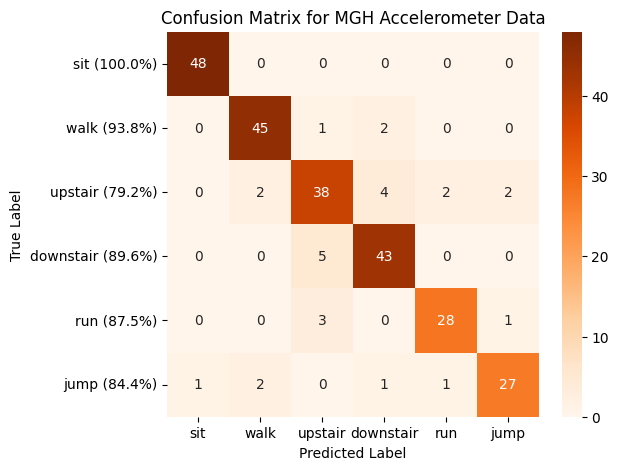

In [27]:
# Get actual labels present in y_test
unique_labels = np.unique(y_test)
filtered_activities = [ACTIVITIES[i] for i in unique_labels]

cm = confusion_matrix(y_test, y_pred, labels=unique_labels)

# Calculate percentages
correct_counts = np.diag(cm) 
total_per_class = cm.sum(axis=1)  
accuracy_per_class = (correct_counts / total_per_class) * 100 

# Format labels for the y-axis (True Label) to include accuracy
yticklabels_with_percent = [
    f"{activity} ({accuracy_per_class[i]:.1f}%)" if total_per_class[i] > 0 else f"{activity} (0%)"
    for i, activity in enumerate(filtered_activities)
]

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=filtered_activities, yticklabels=yticklabels_with_percent)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix for MGH Accelerometer Data")
plt.show()